<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/dc_gan_notebook/DC_GAN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DC GAN adopted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Calculates FID score in PyTorch

In [1]:
import os
import sys
from pathlib import Path
import pdb

Path.ls = lambda x: list(x.iterdir())

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

In [4]:
!git clone https://github.com/azfarkhoja305/GANs.git

Cloning into 'GANs'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 38 (delta 15), reused 32 (delta 13), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [3]:
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [6]:
!python ./GANs/create_fid_stats.py -d cifar_10 -t False

Namespace(dataset='cifar_10', save='fid_stats', train='False')
170499072it [00:03, 53151223.20it/s]                   
Extracting data/cifar_10/cifar-10-python.tar.gz to data/cifar_10
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 98.1MB/s]
100% 100/100 [00:34<00:00,  2.89it/s]
done


In [4]:
from datasets import ImageDataset
from utils.utils import check_gpu, display_images

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [7]:
dataset =  ImageDataset('cifar_10', batch_sz = 256)

Files already downloaded and verified


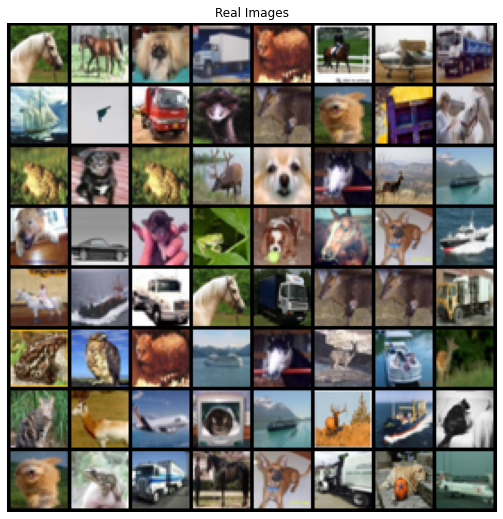

In [8]:
display_images(dataset.train_loader, max_idx=256)

In [11]:
class Generator(nn.Module):
    def __init__(self,z_sz=128,p_sz=1024):
        super().__init__()
        self.p_sz=p_sz
        self.relu = nn.LeakyReLU()
        self.fc = nn.Linear(z_sz,p_sz, bias=False)
        self.bn1d = nn.BatchNorm1d(p_sz)
        self.body = nn.Sequential(
            # 246 x 2 x 2
            nn.PixelShuffle(upscale_factor=2),
            # 64 x 4 x 4
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1, bias=False),
            # 256 x 4 x 4
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.PixelShuffle(upscale_factor=2),
            # 64 x 8 x 8
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1, bias=False),
            # 256 x 8 x 8
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.PixelShuffle(upscale_factor=2),
            # 64 x 16 x 16
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1, bias=False),
            # 256 x 16 x 16
            nn.LeakyReLU(),
            nn.BatchNorm2d(256),
            nn.PixelShuffle(upscale_factor=2),
            # 64 x 32 x 32
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            # 64 x 32 x 32
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1, bias=False),
            # 3 x 32 x 32
            nn.Tanh()
        )

    def forward(self,x):
        x = x.squeeze()
        x = self.bn1d(self.relu(self.fc(x)))
        x = x.view(-1,self.p_sz//4,2,2)
        x = self.body(x)
        return x

In [12]:
Gen = Generator().to(device)
summary(Gen,(128,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]         131,072
         LeakyReLU-2                 [-1, 1024]               0
       BatchNorm1d-3                 [-1, 1024]           2,048
      PixelShuffle-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 256, 4, 4]         147,456
         LeakyReLU-6            [-1, 256, 4, 4]               0
       BatchNorm2d-7            [-1, 256, 4, 4]             512
      PixelShuffle-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         147,456
        LeakyReLU-10            [-1, 256, 8, 8]               0
      BatchNorm2d-11            [-1, 256, 8, 8]             512
     PixelShuffle-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         147,456
        LeakyReLU-14          [-1, 256,

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            # 3 x 32 x 32
            nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1,bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(16,32,kernel_size=4,stride=2,padding=1,bias=False),
            # 32 x 16 x 16
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1,bias=False),
            # 64 x 8 x 8
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
            # 128 x 4 x 4
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0,bias=False),
            # 256 x 1 x 1
        )
        self.linear = nn.Linear(256,1,bias=False)
    def forward(self,x):
        x = self.body(x)
        x = self.linear(x.view(x.size(0),-1))
        return x


In [14]:
Dis = Discriminator().to(device)
summary(Dis,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         LeakyReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 16, 16]           8,192
         LeakyReLU-4           [-1, 32, 16, 16]               0
       BatchNorm2d-5           [-1, 32, 16, 16]              64
            Conv2d-6             [-1, 64, 8, 8]          32,768
         LeakyReLU-7             [-1, 64, 8, 8]               0
       BatchNorm2d-8             [-1, 64, 8, 8]             128
            Conv2d-9            [-1, 128, 4, 4]         131,072
        LeakyReLU-10            [-1, 128, 4, 4]               0
      BatchNorm2d-11            [-1, 128, 4, 4]             256
           Conv2d-12            [-1, 256, 1, 1]         524,288
           Linear-13                    [-1, 1]             256
Total params: 697,456
Trainable params:

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
fixed_noise = torch.randn(64, 128, device=device)
real_label = 1.
fake_label = 0.
lr,beta1 = 3e-4, 0
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, 0.999))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, 0.999))

In [16]:
img_list = []
G_losses = []
D_losses = []
iters = 0

# Number of training epochs
num_epochs = 50

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(dataset.train_loader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        Dis.zero_grad()
        # Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = Dis(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = loss_fn(output,label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = torch.sigmoid(output).mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128, 1,1, device=device)
        # Generate fake image batch with G
        fake = Gen(noise)
        label = torch.full_like(label, fake_label)
        # Classify all fake batch with D
        output = Dis(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_fn(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = torch.sigmoid(output).mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        Gen.zero_grad()
        label = torch.full_like(label,real_label) # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = Dis(fake).view(-1)
        # Calculate G's loss based on this output
        errG = loss_fn(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = torch.sigmoid(output).mean().item()
        # Update G
        optG.step()

        # Output training stats
        if (i+1) %100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(dataset.train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataset.train_loader)-1)):
            with torch.no_grad():
                fake = Gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters +=1
             

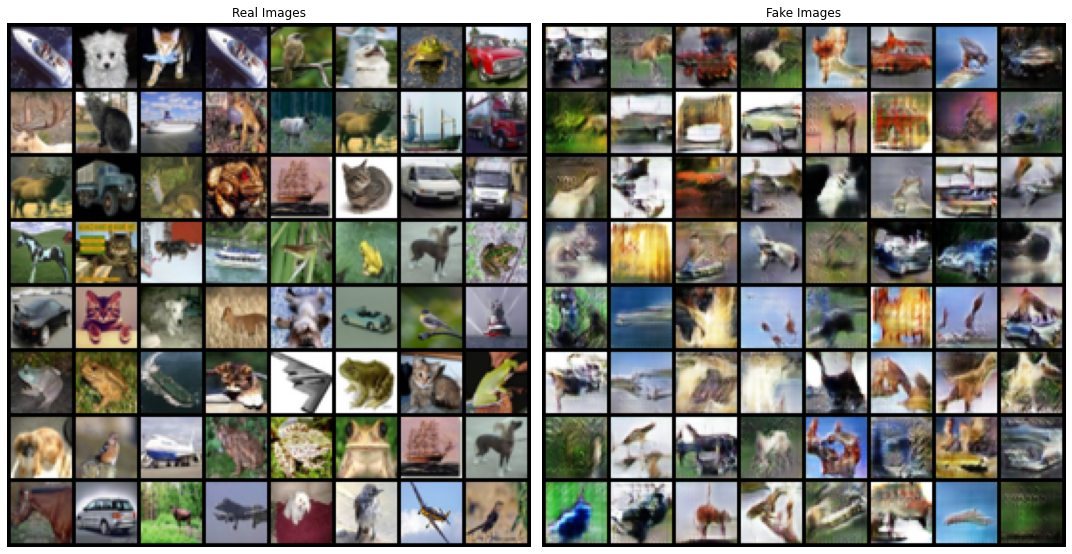

In [18]:
_, axs = plt.subplots(1,2,figsize=(15,15))
display_images(dataset.train_loader,ax = axs[0], max_idx=256)
display_images(img_list, ax = axs[1], max_idx=256)
plt.tight_layout()

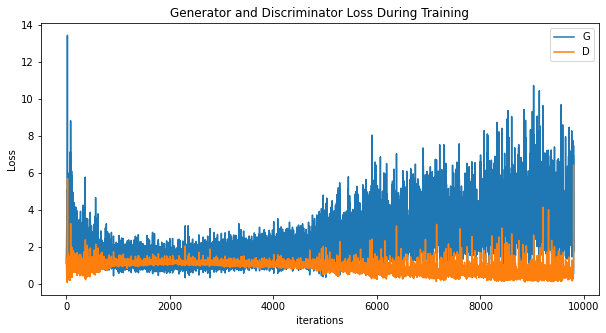

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Calculating FID Score

In [20]:
from utils.torch_fid_score import get_fid

In [21]:
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
score = get_fid(Gen, 128, 10000, 256, stat_path)
print(f"\nFID score: {score}")

Propagating batch 100/100
done

FID score: 50.166839599609375


In [23]:
# rc('animation', html='jshtml')
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani